1 - Select a particular disease according to the ICD9 codes found in the table D_ICD_DIAGNOSES.csv.

We selected the disease related to the circulatory system because it was the most frequent.

2 - Statistical analysis and visualization of data for each patient (SUBJECT_ID). Note: one patient can have more than one hospital admission (HADM_ID).

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

# Load  MIMIC-III tables
base_path = 'C:/Users/Ines/Desktop/Nova_entrega/Parte_topicos/'

icustays_cleaned = pd.read_excel(f'{base_path}icustays_cleaned.xlsx')
admissions_cleaned = pd.read_excel(f'{base_path}admissions_cleaned.xlsx')
diagnoses_icd_cleaned = pd.read_excel(f'{base_path}diagnoses_icd_cleaned.xlsx')
d_items = pd.read_csv(f'{base_path}D_ITEMS.csv')
patients_cleaned = pd.read_excel(f'{base_path}patients_cleaned.xlsx')
chartevents = pd.read_csv(f'{base_path}CHARTEVENTS.csv')

C:\Users\Ines\AppData\Local\Temp\ipykernel_3240\3099920355.py:32: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv(f'{base_path}CHARTEVENTS.csv')


The code is importing data analysis and machine learning libraries, setting up the environment for analysis or predictive modeling.

In [27]:
d_items.info()
print(d_items.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12487 entries, 0 to 12486
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ROW_ID        12487 non-null  int64  
 1   ITEMID        12487 non-null  int64  
 2   LABEL         12483 non-null  object 
 3   ABBREVIATION  2992 non-null   object 
 4   DBSOURCE      12487 non-null  object 
 5   LINKSTO       12487 non-null  object 
 6   CATEGORY      6049 non-null   object 
 7   UNITNAME      851 non-null    object 
 8   PARAM_TYPE    2992 non-null   object 
 9   CONCEPTID     0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 975.7+ KB
   ROW_ID  ITEMID                                        LABEL ABBREVIATION  \
0     457     497  Patient controlled analgesia (PCA) [Inject]          NaN   
1     458     498                            PCA Lockout (Min)          NaN   
2     459     499                               PCA Medication          Na

This code displays a summary of the d_items DataFrame, including the number of entries, data types, and non-null counts with d_items.info(), and then prints the first few rows of the dataset using d_items.head() to give a quick preview of its contents.

In [28]:
d_items = d_items.drop(columns=['ROW_ID','ABBREVIATION','DBSOURCE','LINKSTO', 'CATEGORY','UNITNAME','PARAM_TYPE', 'CONCEPTID'])
d_items_cleaned = d_items.dropna(subset=['LABEL'])
d_items_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12483 entries, 0 to 12486
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ITEMID  12483 non-null  int64 
 1   LABEL   12483 non-null  object
dtypes: int64(1), object(1)
memory usage: 292.6+ KB


In [29]:
diagnoses_icd_cleaned.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9_CATEGORY,recode
0,1297,109,172335,1,40301,Circulatory system,6
1,1298,109,172335,2,486,Respiratory system,7
2,1299,109,172335,3,58281,Genitourinary system,9
3,1300,109,172335,4,5855,Genitourinary system,9
4,1301,109,172335,5,4254,Circulatory system,6


In [30]:
patients_cleaned.info()
patients_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36732 entries, 0 to 36731
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       36732 non-null  int64 
 1   SUBJECT_ID   36732 non-null  int64 
 2   GENDER       36732 non-null  object
 3   DOB          36732 non-null  object
 4   DOD          36732 non-null  object
 5   EXPIRE_FLAG  36732 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.7+ MB


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,0,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,1
2,236,251,M,2090-03-15 00:00:00,0,0
3,237,252,M,2078-03-06 00:00:00,0,0
4,238,253,F,2089-11-26 00:00:00,0,0


In [31]:
subject_ids_recode_6 = diagnoses_icd_cleaned.loc[diagnoses_icd_cleaned['recode'] == 6, 'SUBJECT_ID'].unique()

patients_filtred = patients_cleaned[patients_cleaned['SUBJECT_ID'].isin(subject_ids_recode_6)]
patients_filtred  = patients_filtred .drop(columns=['ROW_ID','DOB','DOD'])
patients_filtred.info()
patients_filtred.head()

<class 'pandas.core.frame.DataFrame'>
Index: 24091 entries, 0 to 36731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SUBJECT_ID   24091 non-null  int64 
 1   GENDER       24091 non-null  object
 2   EXPIRE_FLAG  24091 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 752.8+ KB


,SUBJECT_ID,GENDER,EXPIRE_FLAG
0,249,F,0
1,250,F,1
3,252,M,0
4,253,F,0
5,255,M,0


This code filters the diagnoses_icd_cleaned DataFrame to find unique SUBJECT_IDs where the diagnosis recode equals 6, patients with problems in circulatory system. Then, it selects those patients from the patients_cleaned DataFrame whose SUBJECT_ID is in that list. After that, it drops the columns 'ROW_ID', 'DOB', and 'DOD' from the filtered patients DataFrame, and finally displays the summary info and the first few rows of the resulting filtered DataFrame.

In [32]:
icustays_cleaned.head()
icustays_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61522 entries, 0 to 61521
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ROW_ID          61522 non-null  int64         
 1   SUBJECT_ID      61522 non-null  int64         
 2   HADM_ID         61522 non-null  int64         
 3   ICUSTAY_ID      61522 non-null  int64         
 4   DBSOURCE        61522 non-null  object        
 5   FIRST_CAREUNIT  61522 non-null  object        
 6   LAST_CAREUNIT   61522 non-null  object        
 7   INTIME          61522 non-null  datetime64[ns]
 8   LOS             61522 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 4.2+ MB


In [33]:
admissions_cleaned.head()
admissions_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47365 entries, 0 to 47364
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                47365 non-null  int64 
 1   SUBJECT_ID            47365 non-null  int64 
 2   HADM_ID               47365 non-null  int64 
 3   DEATHTIME             47365 non-null  object
 4   ADMISSION_TYPE        47365 non-null  object
 5   INSURANCE             47365 non-null  object
 6   ETHNICITY             47365 non-null  object
 7   DIAGNOSIS             47348 non-null  object
 8   HOSPITAL_EXPIRE_FLAG  47365 non-null  int64 
 9   HAS_CHARTEVENTS_DATA  47365 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 3.6+ MB


In [34]:
chartevents = chartevents.drop(columns=['ROW_ID','STORETIME', 'CGID', 'VALUENUM','VALUEUOM','WARNING', 'ERROR', 'RESULTSTATUS', 'STOPPED'])
subject_ids_filtrados = patients_filtred['SUBJECT_ID'].unique()

chartevents_filtred = chartevents[chartevents['SUBJECT_ID'].isin(subject_ids_filtrados)]

Using only the 'SUBJECT_ID's of patients who have problems with the circulatory system.

In [35]:
chartevents_filtred.head()
chartevents_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25669878 entries, 0 to 39195629
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ICUSTAY_ID  float64
 3   ITEMID      int64  
 4   CHARTTIME   object 
 5   VALUE       object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.3+ GB


In [36]:
chartevents_filt_com_label = chartevents_filtred.merge(
    d_items_cleaned[['ITEMID', 'LABEL']], 
    on='ITEMID',
    how='left'
)

chartevents_filt_com_icu = chartevents_filt_com_label.merge(
    icustays_cleaned[['INTIME','LOS','ICUSTAY_ID']],
    on='ICUSTAY_ID',
    how='left'
)

df_final = chartevents_filt_com_icu.merge(
    admissions_cleaned[['HADM_ID','DIAGNOSIS','HAS_CHARTEVENTS_DATA','DEATHTIME','ADMISSION_TYPE','ETHNICITY','HOSPITAL_EXPIRE_FLAG']],
    on='HADM_ID',
    how='left'
)


This code enriches the filtered clinical events data by sequentially merging it with descriptive item labels from d_items_cleaned, ICU stay details from icustays_cleaned, and hospital admission information from admissions_cleaned. Each merge is performed using relevant keys (ITEMID, ICUSTAY_ID, and HADM_ID) to combine clinical, ICU, and admission data into a single comprehensive dataset called df_final.

In [37]:
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25669878 entries, 0 to 25669877
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   SUBJECT_ID            int64         
 1   HADM_ID               int64         
 2   ICUSTAY_ID            float64       
 3   ITEMID                int64         
 4   CHARTTIME             object        
 5   VALUE                 object        
 6   LABEL                 object        
 7   INTIME                datetime64[ns]
 8   LOS                   float64       
 9   DIAGNOSIS             object        
 10  HAS_CHARTEVENTS_DATA  float64       
 11  DEATHTIME             object        
 12  ADMISSION_TYPE        object        
 13  ETHNICITY             object        
 14  HOSPITAL_EXPIRE_FLAG  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 2.9+ GB
None
   SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID            CHARTTIME  VALUE  \
0          

In [38]:
null_counts = df_final.isnull().sum()
print(null_counts)
len(df_final)

SUBJECT_ID                    0
HADM_ID                       0
ICUSTAY_ID                32977
ITEMID                        0
CHARTTIME                     0
VALUE                    133025
LABEL                         0
INTIME                    32977
LOS                       32977
DIAGNOSIS               7949856
HAS_CHARTEVENTS_DATA    7949856
DEATHTIME               7949856
ADMISSION_TYPE          7949856
ETHNICITY               7949856
HOSPITAL_EXPIRE_FLAG    7949856
dtype: int64


25669878

This code calculates and prints the number of missing (null) values in each column of the df_final DataFrame using isnull().sum(). It then prints the total number of rows in df_final with len(df_final).

In [39]:
df_final = df_final[df_final['HAS_CHARTEVENTS_DATA'].notna()]
df_final = df_final.drop(columns=['HAS_CHARTEVENTS_DATA'])
print(df_final.head())
len(df_final)

   SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID            CHARTTIME  VALUE  \
0          36   165660    241249.0  223834  2134-05-12 12:00:00   15.0   
1          36   165660    241249.0  223835  2134-05-12 12:00:00  100.0   
2          36   165660    241249.0  224328  2134-05-12 12:00:00   0.37   
3          36   165660    241249.0  224329  2134-05-12 12:00:00    6.0   
4          36   165660    241249.0  224330  2134-05-12 12:00:00    2.5   

                  LABEL              INTIME     LOS           DIAGNOSIS  \
0               O2 Flow 2134-05-12 06:52:47  4.3483  VENTRAL HERNIA/SDA   
1  Inspired O2 Fraction 2134-05-12 06:52:47  4.3483  VENTRAL HERNIA/SDA   
2              PCA dose 2134-05-12 06:52:47  4.3483  VENTRAL HERNIA/SDA   
3     PCA lockout (min) 2134-05-12 06:52:47  4.3483  VENTRAL HERNIA/SDA   
4      PCA 1 hour limit 2134-05-12 06:52:47  4.3483  VENTRAL HERNIA/SDA   

  DEATHTIME ADMISSION_TYPE ETHNICITY  HOSPITAL_EXPIRE_FLAG  
0         0       ELECTIVE     WHITE       

17720022

This code filters df_final to keep only the rows where the HAS_CHARTEVENTS_DATA column is not null, then drops the HAS_CHARTEVENTS_DATA column entirely. Finally, it prints the first few rows of the updated DataFrame and outputs the total number of remaining rows.

                   LABEL  LABEL_ENCODED
23088708  % Inspir. Time              0
24977457          10 min              1
24977456           5 min              2
25505467             ABG              3
23714297         ABI (L)              4
...                  ...            ...
24369677        rotation           1343
23686468      trach care           1344
23295827          versed           1345
23045436          zzO2AV           1346
23045437         zzO2AVI           1347

[1348 rows x 2 columns]
                                                  DIAGNOSIS  DIAGNOSIS_ENCODED
6557286           MITRAL STENOSIS\MITRAL VALVE REPLACEME...                  0
16856255                                              STEMI                  1
5635665    THORACIC ANEURYSM\REPLACEMENT OF ASCENDING AO...                  2
3743373                    (AML) ACUTE MYELOGENOUS LEUKEMIA                  3
16524316                                         + TROPONIN                  4
...                  

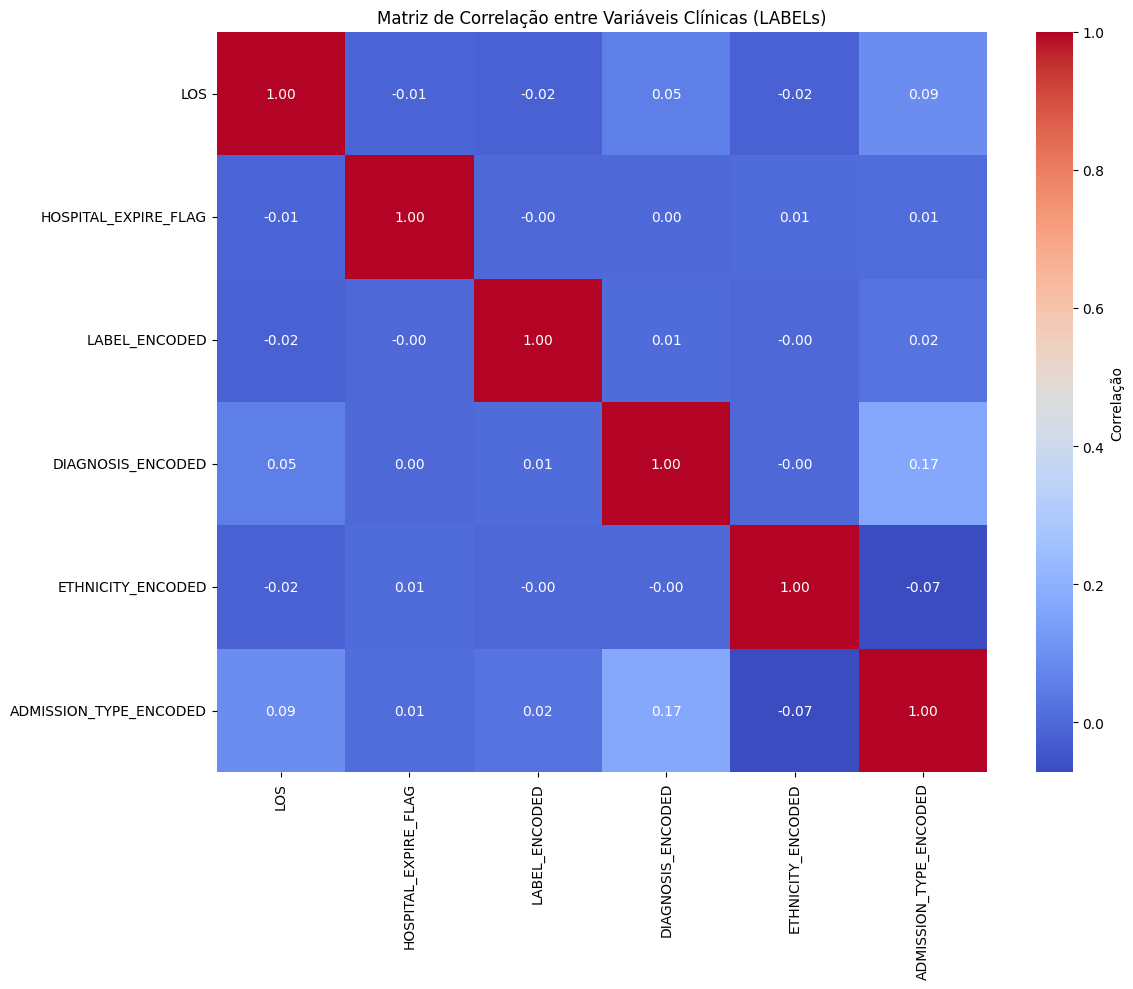

In [40]:
df_corr = df_final.drop(columns=['INTIME','CHARTTIME'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_cols = ['LABEL', 'DIAGNOSIS', 'ETHNICITY','ADMISSION_TYPE']

for col in categorical_cols:
    le = LabelEncoder()
    df_corr[col + '_ENCODED'] = le.fit_transform(df_corr[col])

print(df_corr[['LABEL', 'LABEL_ENCODED']].drop_duplicates().sort_values('LABEL_ENCODED'))
print(df_corr[['DIAGNOSIS', 'DIAGNOSIS_ENCODED']].drop_duplicates().sort_values('DIAGNOSIS_ENCODED'))
print(df_corr[['ETHNICITY', 'ETHNICITY_ENCODED']].drop_duplicates().sort_values('ETHNICITY_ENCODED'))
print(df_corr[['ADMISSION_TYPE', 'ADMISSION_TYPE_ENCODED']].drop_duplicates().sort_values('ADMISSION_TYPE_ENCODED'))

df_corr = df_corr.drop(columns=categorical_cols)

print(df_corr.columns)

df_corr = df_corr.select_dtypes(include=['number'])

print(df_corr.columns)

df_corr = df_corr.drop(columns=[col for col in ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','ITEMID'] if col in df_corr.columns])

corr_matrix = df_corr.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar_kws={'label': 'Correlação'})
plt.title("Matriz de Correlação entre Variáveis Clínicas (LABELs)")
plt.tight_layout()
plt.show()

This code prepares the dataset for correlation analysis by first dropping the INTIME and CHARTTIME columns, then encoding categorical variables (LABEL, DIAGNOSIS, ETHNICITY, ADMISSION_TYPE) into numeric labels using LabelEncoder. It prints unique mappings for these encoded columns for inspection, removes the original categorical columns, and keeps only numeric columns. After dropping identifier columns if present, it calculates the correlation matrix and visualizes it as a heatmap to show the relationships between clinical variables.

Here we see that there are weak correlations between the features, with the strongest being between DIAGNOSIS_ENCODED and ADMISSION_TYPE_ENCODED (0.17).

In [41]:
admissions_per_patient = df_final.groupby('SUBJECT_ID')['HADM_ID'].nunique()
print(admissions_per_patient.describe())


count    11279.000000
mean         1.199574
std          0.705271
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: HADM_ID, dtype: float64


The HADM_ID column shows that most hospital admissions are associated with a single event, though a few patients have up to 17 admissions, indicating potential outliers or frequent readmissions.

In [42]:
subject_17_admissions = admissions_per_patient[admissions_per_patient == 17].index.tolist()

print("SUBJECT_ID(s) com 17 admissões:", subject_17_admissions)

icustay_ids = df_final[df_final['SUBJECT_ID'].isin(subject_17_admissions)][['SUBJECT_ID', 'ICUSTAY_ID']].drop_duplicates()

print(icustay_ids)


SUBJECT_ID(s) com 17 admissões: [5060, 73713]
          SUBJECT_ID  ICUSTAY_ID
220515          5060    219030.0
220537          5060    296807.0
220601          5060    231947.0
220628          5060    273958.0
220668          5060    277167.0
220973          5060    256198.0
221596          5060    293174.0
222235          5060    251732.0
223795          5060    225481.0
223844          5060    299704.0
223906          5060    282330.0
224001          5060    292918.0
224030          5060    210613.0
224161          5060    202614.0
224805          5060    264140.0
225217          5060    263247.0
227499          5060    274239.0
15155155       73713    258733.0
15159952       73713    202480.0
15164533       73713    237754.0
15179672       73713    297878.0
15189890       73713    268926.0
15194367       73713    222060.0
15194430       73713    234857.0
15199488       73713    256024.0
15199551       73713    285191.0
15205011       73713    267246.0
15537963       73713    264851

We see that two patients experienced the maximum of 17 ICU stays, indicating cases of frequent or complex readmissions.

C:\Users\Ines\AppData\Local\Temp\ipykernel_3240\2466056950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
C:\Users\Ines\AppData\Local\Temp\ipykernel_3240\2466056950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])


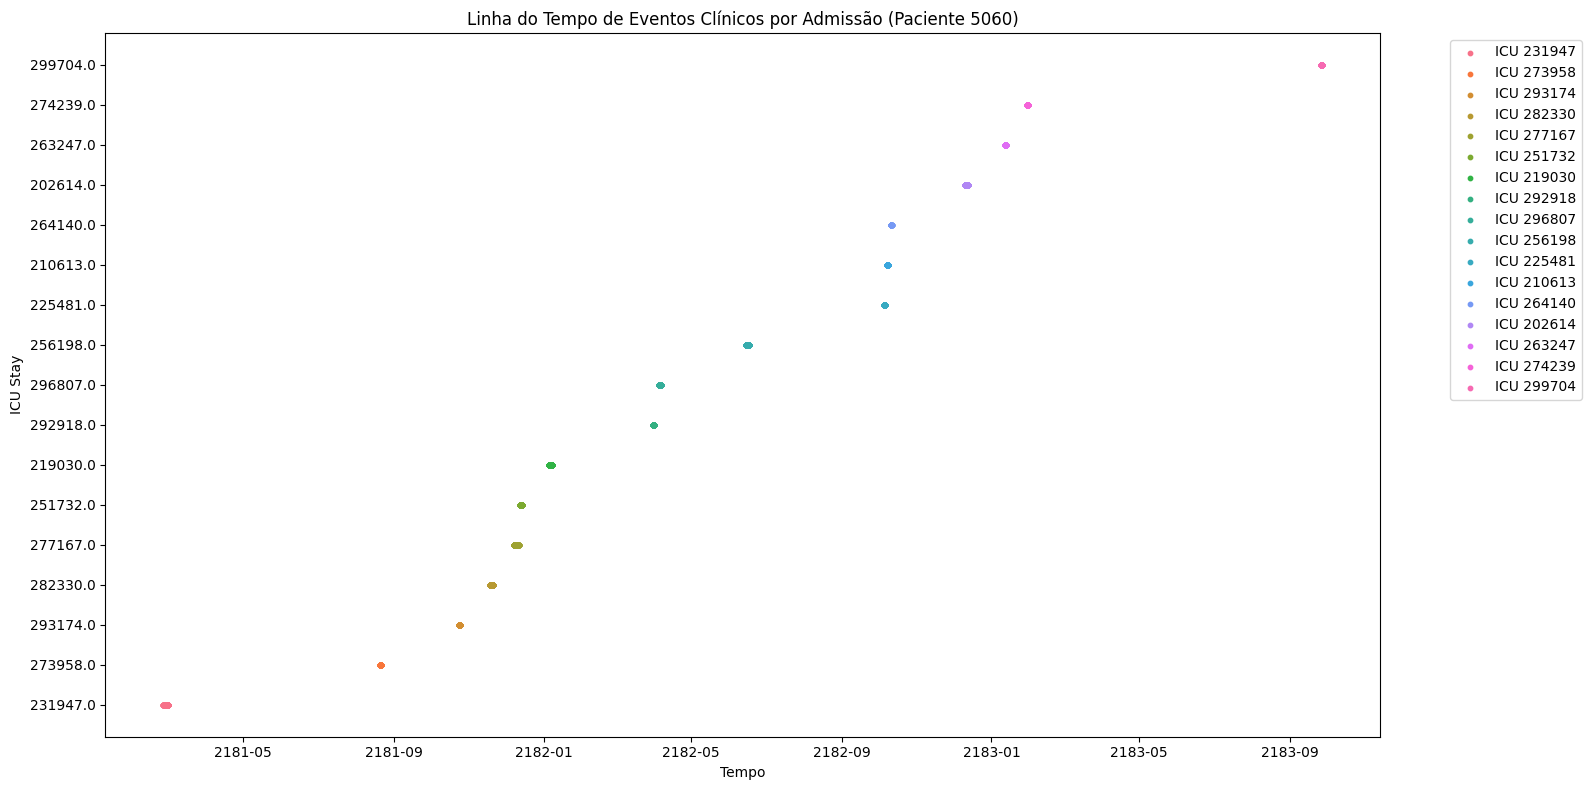

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_final[df_final['SUBJECT_ID'] == 5060]
df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
df['INTIME'] = pd.to_datetime(df['INTIME'])

df = df.sort_values(by='CHARTTIME')

unique_stays = df['ICUSTAY_ID'].unique()
palette = sns.color_palette("husl", len(unique_stays))
color_dict = {stay: palette[i] for i, stay in enumerate(unique_stays)}

plt.figure(figsize=(16, 8))

for stay in unique_stays:
    stay_data = df[df['ICUSTAY_ID'] == stay]
    plt.scatter(stay_data['CHARTTIME'], [str(stay)] * len(stay_data), 
                color=color_dict[stay], label=f'ICU {int(stay)}', s=10)

plt.xlabel("Tempo")
plt.ylabel("ICU Stay")
plt.title("Linha do Tempo de Eventos Clínicos por Admissão (Paciente 5060)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The provided code generates a scatter plot timeline that visualizes the clinical events of a specific patient (with `SUBJECT_ID` 5060), organized by each of their ICU stays. First, it filters the dataset to include only records related to this patient. Then, it converts the `CHARTTIME` and `INTIME` columns to datetime format to ensure proper time-based plotting. The data is sorted chronologically based on `CHARTTIME`. Each unique ICU stay (`ICUSTAY_ID`) is identified, and a distinct color is assigned to each one using Seaborn’s color palette. The plot is initialized with a specified figure size, and for every ICU stay, the code selects the corresponding data and plots each event as a small point (`s=10`) on the timeline. These points are aligned on the y-axis by their ICU stay ID, while the x-axis represents the actual time of the clinical events. The plot is labeled accordingly, with axis titles and a legend that identifies each ICU stay by color. The legend is positioned to the side of the plot for better readability. Finally, `plt.show()` is called to display the timeline, which allows the user to visually explore when and during which ICU stays the patient’s clinical events occurred.

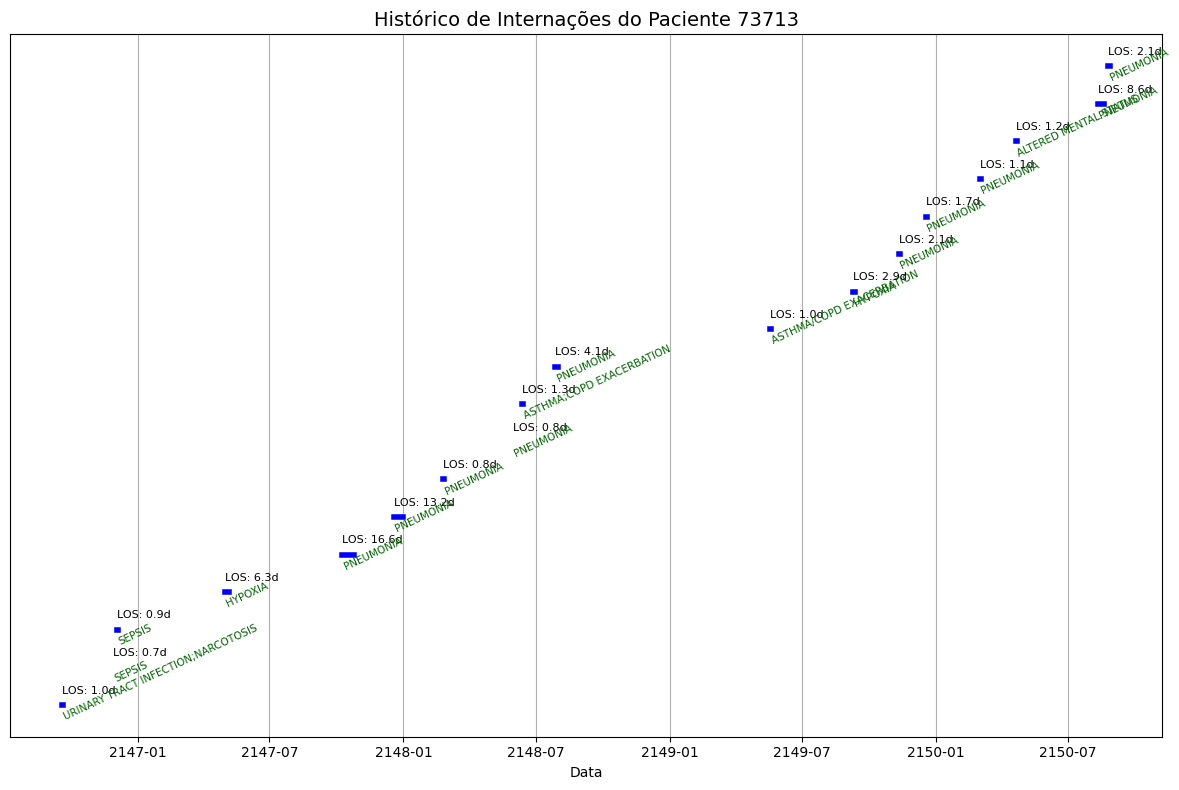

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

subject_id = 73713
df_patient = df_final[df_final['SUBJECT_ID'] == subject_id].drop_duplicates(subset='ICUSTAY_ID').copy()

df_patient = df_patient.sort_values(by='INTIME').reset_index(drop=True)

plt.figure(figsize=(12, 8))

for idx, row in df_patient.iterrows():
    start = row['INTIME']
    end = row['INTIME'] + pd.to_timedelta(row['LOS'], unit='d')

    plt.plot([start, end], [idx, idx], color='blue', linewidth=4)

    plt.text(start, idx + 0.3, f"LOS: {row['LOS']:.1f}d", fontsize=8)

    plt.text(start, idx - 0.4, f"{row['DIAGNOSIS']}", fontsize=7.5, color='darkgreen', rotation=25)

plt.title(f"Histórico de Internações do Paciente {subject_id}", fontsize=14)
plt.xlabel("Data")
plt.yticks([])
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()



Here, the same analysis is performed for the other patient, but this time including the description of each diagnosis to provide more clinical context for each admission.

C:\Users\Ines\AppData\Local\Temp\ipykernel_3240\756349837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
C:\Users\Ines\AppData\Local\Temp\ipykernel_3240\756349837.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])


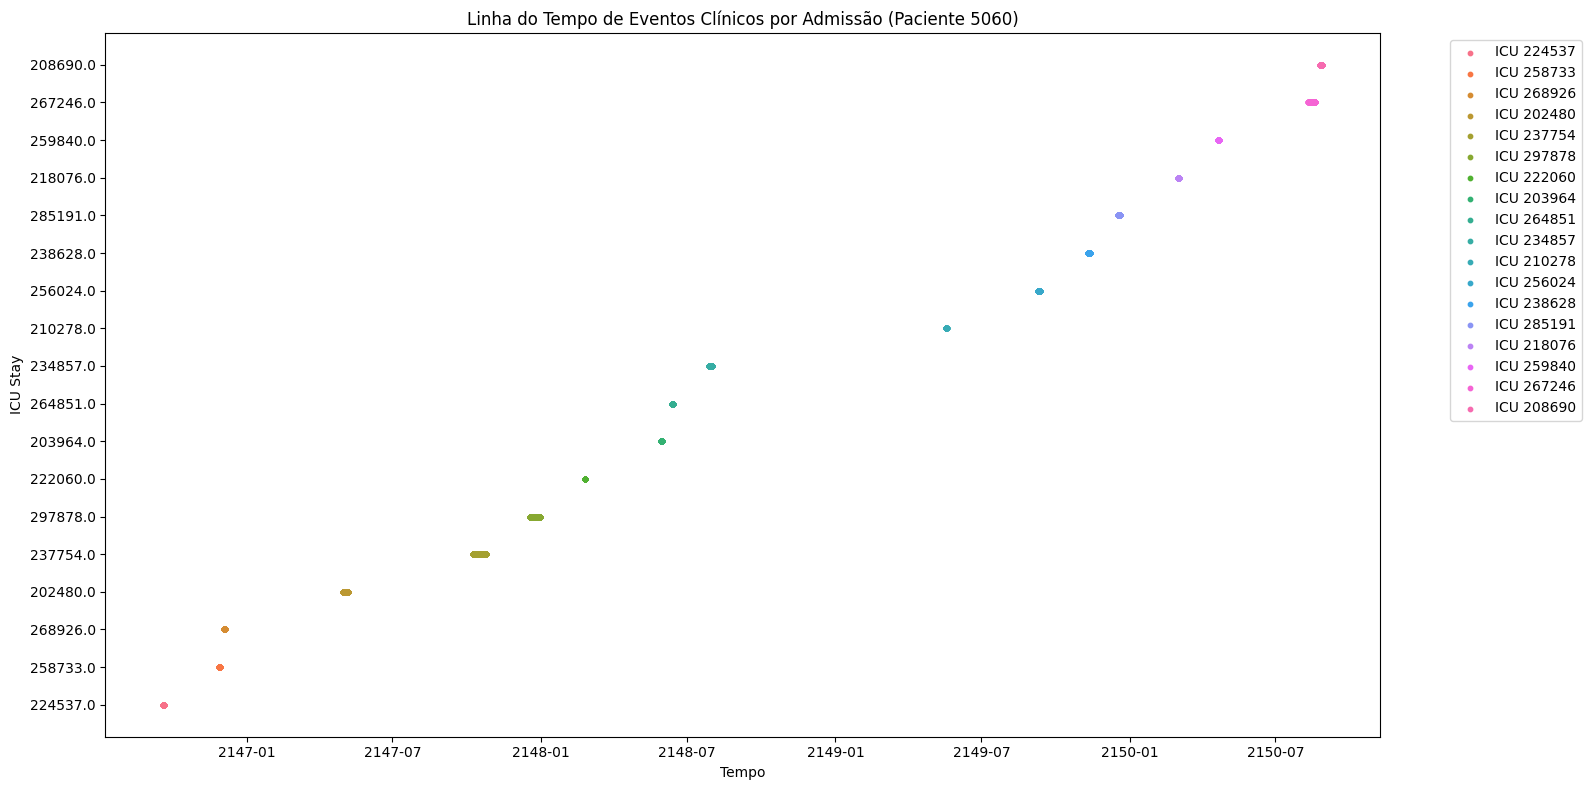

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_final[df_final['SUBJECT_ID'] == 73713] 
df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
df['INTIME'] = pd.to_datetime(df['INTIME'])

df = df.sort_values(by='CHARTTIME')

unique_stays = df['ICUSTAY_ID'].unique()
palette = sns.color_palette("husl", len(unique_stays))
color_dict = {stay: palette[i] for i, stay in enumerate(unique_stays)}

plt.figure(figsize=(16, 8))

for stay in unique_stays:
    stay_data = df[df['ICUSTAY_ID'] == stay]
    plt.scatter(stay_data['CHARTTIME'], [str(stay)] * len(stay_data), 
                color=color_dict[stay], label=f'ICU {int(stay)}', s=10)

plt.xlabel("Tempo")
plt.ylabel("ICU Stay")
plt.title("Linha do Tempo de Eventos Clínicos por Admissão (Paciente 5060)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [53]:
mean_los_per_patient = df_final.groupby('SUBJECT_ID')['LOS'].mean()
print(mean_los_per_patient.head())

stats = mean_los_per_patient.describe()
print(stats)                                                                          

SUBJECT_ID
4     1.678500
6     3.672900
13    3.666000
17    1.546971
18    1.288500
Name: LOS, dtype: float64
count    11276.000000
mean         3.556240
std          4.719639
min          0.056600
25%          1.216675
50%          2.041450
75%          3.753772
max         88.374089
Name: LOS, dtype: float64


This code calculates the average ICU length of stay (LOS) for each patient by grouping the df_final DataFrame by SUBJECT_ID and computing the mean. It then prints the first few results to show the average ICU stay per patient.

This output shows the average ICU length of stay (LOS) in days for a few patients. For example, patient 6 has a longer average stay (3.67 days), while patient 18 has a shorter one (1.29 days). This suggests variability in ICU needs, possibly reflecting differences in illness severity or complexity of care.

The descriptive statistics of the Length of Stay (LOS) for ICU patients, measured in days, reveal a highly variable distribution. The average LOS is approximately 3.56 days, with a standard deviation of 4.72 days, indicating considerable variability among patients. The median LOS is 2.04 days, suggesting that half of the patients stay in the ICU for less than this duration. The 25th percentile is 1.22 days, and the 75th percentile is 3.75 days, showing that the majority of patients stay between 1.22 and 3.75 days. However, the maximum LOS of 88.37 days highlights the presence of significant outliers, which is also suggested by the large gap between the mean and the maximum. These findings indicate that while most ICU stays are relatively short, a small proportion of patients experience prolonged admissions.

In [54]:
diagnosis_per_patient = df_final.groupby('SUBJECT_ID')['DIAGNOSIS'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)


The goal is to obtain the most frequent diagnosis (mode) for each patient (SUBJECT_ID), with care taken to avoid errors in cases where no values are available.

In [55]:
df_final['CHARTTIME'] = pd.to_datetime(df_final['CHARTTIME'], errors='coerce')
df_final['INTIME'] = pd.to_datetime(df_final['INTIME'], errors='coerce')

df_final = df_final.dropna(subset=['CHARTTIME', 'INTIME'])

df_final['hours_since_admit'] = (df_final['CHARTTIME'] - df_final['INTIME']).dt.total_seconds() / 3600

df_icu = df_final[df_final['hours_since_admit'] <= 24].copy()

df_icu['day_fraction'] = df_icu['hours_since_admit'] / 24


Preparing ICU data by focusing on the first 24 hours after admission and expressing the timing of each event as a fraction of that first day. This approach helps analyze patient measurements in a normalized way, based on how far into their ICU stay the events occurred.

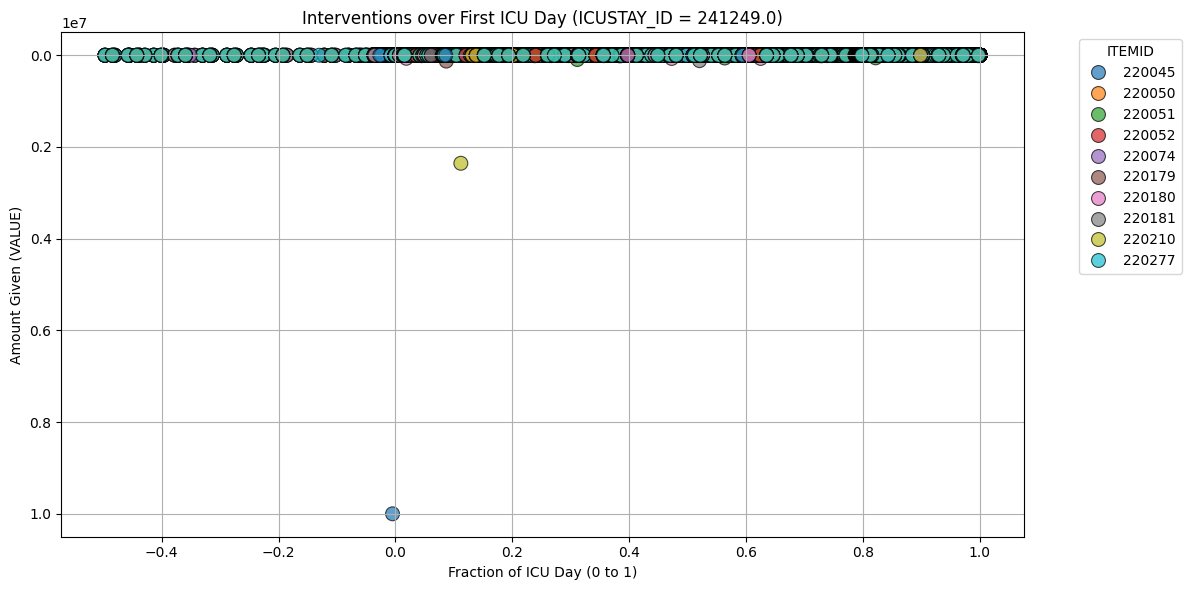

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

top_items = df_icu['ITEMID'].value_counts().nlargest(10).index

df_top_items = df_icu[df_icu['ITEMID'].isin(top_items)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_top_items,
    x='day_fraction',
    y='VALUE',
    hue='ITEMID',
    palette='tab10',
    s=100,
    edgecolor='black',
    alpha=0.7
)

ICUSTAY_ID = df_top_items['ICUSTAY_ID'].iloc[0]

plt.xlabel('Fraction of ICU Day (0 to 1)')
plt.ylabel('Amount Given (VALUE)')
plt.title(f'Interventions over First ICU Day (ICUSTAY_ID = {ICUSTAY_ID})')
plt.legend(title='ITEMID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


This code visualizes the top 10 most frequent clinical items (ITEMID) recorded during ICU stays within the first day. It filters the ICU data (df_icu) to include only these top items, then creates a scatter plot showing the values (VALUE) of each item against the fraction of the ICU day when they occurred (day_fraction, ranging from 0 to 1). Each item is color-coded for distinction, and the plot includes labels, a title referencing a specific ICU stay (ICUSTAY_ID), a legend, and grid lines for clarity. This helps analyze how different interventions or measurements vary over the first 24 hours of ICU admission.